In [33]:
!pip install matplotlib-venn

In [1]:
!pip install wandb -qqq
import wandb
wandb.login()

wandb: Currently logged in as: manideepladi (use `wandb login --relogin` to force relogin)


True

In [2]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_mtx(matrix,num_classes):

  plt.figure(figsize=(10,8))
  ax= plt.subplot()
  cmap=sns.light_palette("blue")
  sns.heatmap(matrix, annot=True, ax = ax,fmt=".3f"); 
  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels');
  ax.set_title('Confusion Matrix');
  ax.xaxis.set_ticklabels([str(i) for i in range(num_classes)]); ax.yaxis.set_ticklabels([str(i) for i in range(num_classes)]);
  plt.show()

In [3]:
from keras.datasets import fashion_mnist
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()
labels=["T-shirt/top","Trouser","Pullover","Dress","Coat",
        "Sandal","Shirt","Sneaker","Bag","Ankle boot"]

Question 1: Download the fashion-MNIST dataset and plot 1 sample image for each class as shown in the grid below. Use "from keras.datasets import fashion_mnist" for getting the fashion mnist dataset.

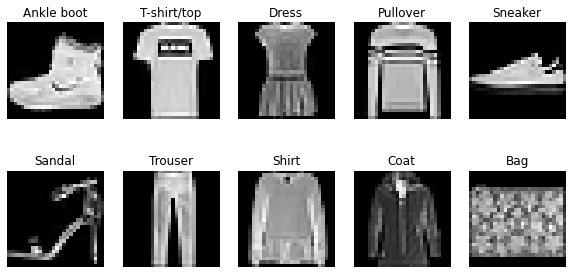

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5)) 

plottedClass =  [False for i in range(10)] 
count=0
for i in range(25):
    if  plottedClass[Y_train[i]]==False:
      plt.subplot(2,5,count+1).set_title(labels[Y_train[i]]) 
      plt.imshow(X_train[i],cmap='gray')
      plt.axis("off")
      plottedClass[Y_train[i]]=True
      count=count+1

plt.show()

**Backpropagation code stage1.**

In [5]:
import numpy as np
import math
from tensorflow.keras import initializers

In [6]:
from sklearn.preprocessing import OneHotEncoder

#flatten the Xtrain and X_test
X_train=X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
X_test=X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2]))

#create one hot encoding of the labels
Y_train_ohe=OneHotEncoder().fit_transform(Y_train.reshape(-1,1)).toarray()
Y_test_ohe=OneHotEncoder().fit_transform(Y_test.reshape(-1,1)).toarray()


#normalizing the train data and test data...
X_train=X_train/255
X_test=X_test/255

In [7]:
class Activation:

  def Sigmoid(self,x):
    return 1/(1+np.exp(-x))

  def Softmax(self,x):
    numr=np.exp(x)
    return numr/(np.sum(numr))

  def Relu(self,x):
    return 1

  def Tanh(self,x):
    numr=np.exp(x)-np.exp(-x)
    denom=np.exp(x)+np.exp(-x)
    return numr/denom

  def Derivative_Sigmoid(self,x):
    s=1/(1+np.exp(-x))
    return s*(1-s)

  def Derivative_Relu(self,x):
    return 1  

  def Derivative_Tanh(self,x):
    return 1-self.Tanh(x)**2

  def Linear(self,x):
    return x


In [8]:
class Loss:

  #Takes ypred as [[],[]] and y as [[],[]]
  def CategoricalCrossEntropy(self,ypred,y):
    
    class_idx=np.argmax(y,axis=1)
    cce_loss=0
    for i in range(len(class_idx)):
      cce_loss+=(-1)*np.log2(ypred[i][class_idx[i]])

    return cce_loss/len(ypred)


  def meansquarederror(self,ypred,y):

    #check for correct squared loss function
    return np.sum((ypred-y)**2)/len(ypred)



In [9]:
class Layer:

  def __init__(self,num_inputs,num_neurons,activation,optimizer,layerInitialization):
    
    self.num_inputs=num_inputs
    self.num_neurons=num_neurons
    self.activation=activation
    self.optimizer=optimizer
    if layerInitialization=="Random":
      self.W=np.random.randn(self.num_neurons,self.num_inputs)
      self.b=np.random.randn(self.num_neurons,)
    elif layerInitialization=="Xavier":
      initializer = tf.keras.initializers.GlorotUniform()
      self.W=initializer(self.num_neurons,self.num_inputs)
      self.b=initializer(self.num_neurons,)

    self.aL=0
    self.hL=0
    self.del_h=0
    self.del_a=0
    self.delW=0
    self.delb=0

    #prev params for Moment based annd nestrov
    self.prev_Uw=0
    self.prev_Ub=0

    #vt for Rmsprop
    self.prev_Vw=0
    self.prev_Vb=0

    #mt for Adam.
    self.prev_Mw=0
    self.prev_Mb=0
  

  def Forward(self,h_L_1):
    
    self.aL=np.dot(self.W,h_L_1)+self.b

    if self.activation=="Relu":
      self.hL=Activation().Relu(self.aL)

    elif self.activation=="Tanh":
      self.hL=Activation().Tanh(self.aL)
    
    elif self.activation=="Softmax":
      self.hL=Activation().Softmax(self.aL)
    
    elif self.activation=="Linear":
      self.hL=Activation().Linear(self.aL)

    elif self.activation == 'Sigmoid':
      self.hL=Activation().Sigmoid(self.aL)
    
    else:
      raise Exception("choose a valid activation from {'Sigmoid','Tanh','Relu','Softmax','Linear'}")

    
  def get_gradients(self,isoplayer,Y_hat,Y,prev_hL,nextW,next_del_a):
      
      #If it is the output layer...
      if isoplayer==1:

        if self.activation=='Softmax':
          for i in range(len(Y_hat)):
            self.del_h+=((-1/Y_hat[i][np.argmax(Y[i])])*Y[i])
          
          self.del_h/=len(Y)
          
          for i in range(len(Y_hat)):  
            self.del_a+=(Y_hat[i]-Y[i])
          
          self.del_a/=len(Y)
      
      #write the gradients formula for linear activation...
        elif self.activation == 'Linear':
          for i in range(len(Y_hat)):
            self.del_h+=2*(Y_hat[i] - Y[i])
          
          self.del_h/=len(Y)

          self.del_a = self.del_h

        
        else:
          raise Exception("!!! The activation passed is not yet Implemented...")

      #if it is not the output layer..
      else:
        self.del_h = np.dot((nextW).T,next_del_a)

        #gradients wrt pre activation for different Activation function used..
        if self.activation=="Relu":
          self.del_a=(self.del_h)*(Activation().Derivative_Relu(self.aL))

        elif self.activation=="Tanh":
          self.del_a=(self.del_h)*(Activation().Derivative_Tanh(self.aL))
      
        else:
          self.del_a=(self.del_h)*(Activation().Derivative_Sigmoid(self.aL))


      
      self.delW=np.dot(self.del_a.reshape(-1,1),prev_hL.reshape(1,-1))
      self.delb=self.del_a

    
  def reset_gradients(self):
    
    self.del_h=0
    self.del_a=0
    self.delW=0
    self.delb=0

  

In [10]:
class IpLayer:

  def __init__(self,num_neurons):
    self.num_neurons=num_neurons
    self.hL=0

  def Forward(self,x):
    self.hL=x


In [11]:
class NN:

  def __init__(self,input_shape,num_hlayers,neurons,hiddenLayerActivation,outputActivation,optimizer,learningrate,layerInitialization,output_shape):

    self.input_shape=input_shape
    self.output_shape=output_shape
    self.num_hlayers=num_hlayers
    self.neurons=neurons
    self.HLAc=hiddenLayerActivation
    self.OPAc=outputActivation
    self.optimizer=optimizer

    self.Layers=[]
    self.eta=1e-3

    #variables for different optimizers
    self.gamma=learningrate
    self.beta=0.8
    self.epsilon=1e-5
    self.beta1=0.9
    self.beta2=0.999
    
    #create input layer
    self.Layers.append(IpLayer(self.input_shape))

    #hidden layers..
    for layer in range(1,self.num_hlayers+2):
      
      ip_shape=self.Layers[layer-1].num_neurons

      #output layer...
      if layer==self.num_hlayers+1:
         self.Layers.append(Layer(ip_shape,self.output_shape,self.OPAc,self.optimizer,layerInitialization))
      
      else:
        self.Layers.append(Layer(ip_shape,self.neurons[layer-1],self.HLAc,self.optimizer,layerInitialization))
  
  
  # <<<<<<FOR OTHER OPTIMIZERS ADJUST THIS FUNCTION>>>>>>> #
  def Do_one_Pass(self,X,Y,iteration):
    
    Y_hat=[]

    #<<<<IF is it nestrov or nadam update W and b for each layer to W_lookahead and b_lookahead and get gradients at these points.>>>>>

    if self.optimizer=='Nestrov' or self.optimizer=='Nadam':
      #Get look aheads Wla and bla for each layer...
      for i in range(1,self.num_hlayers+2):
        self.Layers[i].W = self.Layers[i].W - self.gamma * self.Layers[i].prev_Uw
        self.Layers[i].b = self.Layers[i].b - self.gamma * self.Layers[i].prev_Ub

     
    #1.Do feed forward... and get Y_hat...
    for i in range(X.shape[0]):
      #get the data in input layer
      self.Layers[0].Forward(X[i])
      #pass the data to the hl+ol
      for j in range(1,self.num_hlayers+2):
        h_L_1=self.Layers[j-1].hL
        self.Layers[j].Forward(h_L_1)

      ypred=self.Layers[self.num_hlayers+1].hL
      Y_hat.append(ypred)
      

    #2 Do back propogation...
    for i in range(self.num_hlayers+1,0,-1):
      prev_hL=self.Layers[i-1].hL
      if i==self.num_hlayers+1:
        self.Layers[i].get_gradients(1,Y_hat,Y,prev_hL,0,0)
      else:
        next_W=self.Layers[i+1].W
        next_del_a=self.Layers[i+1].del_a
        self.Layers[i].get_gradients(0,Y_hat,Y,prev_hL,next_W,next_del_a)
      
      
    #3.Update parameters for each layer...
    for i in range(1,self.num_hlayers+2):

      if self.optimizer == 'Simple_GD':
        self.Layers[i].W = self.Layers[i].W - (self.eta)*(self.Layers[i].delW)
        self.Layers[i].b = self.Layers[i].b - (self.eta)*(self.Layers[i].delb)

      elif self.optimizer == 'Moment_Based' or self.optimizer == 'Nestrov':

        #get momentum..
        Uw_t = (self.gamma) * (self.Layers[i].prev_Uw) + (self.eta) * (self.Layers[i].delW)
        Ub_t = self.gamma * self.Layers[i].prev_Ub + (self.eta) * (self.Layers[i].delb)

        #update the parameters..
        self.Layers[i].W = self.Layers[i].W - Uw_t
        self.Layers[i].b = self.Layers[i].b - Ub_t

        #update the moments..
        self.Layers[i].prev_Uw = Uw_t
        self.Layers[i].prev_Ub = Ub_t

      elif self.optimizer == 'RMSProp':

        #get vt's and update history..
        self.Layers[i].prev_Vw = (self.beta)*(self.Layers[i].prev_Vw) + (1-self.beta)*(self.Layers[i].delW)**2   ##this needed to be checked scalar or not
        self.Layers[i].prev_Vb = (self.beta)*(self.Layers[i].prev_Vb) + (1-self.beta)*(self.Layers[i].delb)**2.   ##this too...

        #update the parameters..
        self.Layers[i].W = self.Layers[i].W - (self.eta/np.sqrt(self.prev_Vw+self.epsilon)* (self.Layers[i].delW))
        self.Layers[i].b = self.Layers[i].b - (self.eta/np.sqrt(self.prev_Vb+self.epsilon)* (self.Layers[i].delb))


      elif self.optimizer == 'Adam' or self.optimizer == 'Nadam':

        #1>> Get the moment update: M_w=beta1*prev_Mw+(1-beta1)*(delW) and  M_b=beta1*prev_Mb+(1-beta1)*(delb)
        #update previous history..
        self.Layers[i].prev_Mw = self.beta1 * self.Layers[i].prev_Mw + (1-self.beta1) * (self.Layers[i].delW)
        self.Layers[i].prev_Mb = self.beta1 * self.Layers[i].prev_Mb + (1-self.beta1) * (self.Layers[i].delb)

        
        #2>> Get the learning rate update: Vw=beta2*(V_w[t-1])+(1-beta2)*(delW)**2
        self.Layers[i].prev_Vw = self.beta2 * self.Layers[i].prev_Vw + (1-self.beta2) * (self.Layers[i].delW)**2
        self.Layers[i].prev_Vb = self.beta2 * self.Layers[i].prev_Vb + (1-self.beta2) * (self.Layers[i].delb)**2

        #3>> Get m^W,V^W and m^b and V^b
        m_w_hat = self.Layers[i].prev_Mw/(1 - math.pow(self.beta1,iteration+1))
        m_b_hat = self.Layers[i].prev_Mb/(1-math.pow(self.beta1,iteration+1))

        v_w_hat = self.Layers[i].prev_Vw/(1-math.pow(self.beta2,iteration+1))
        v_b_hat = self.Layers[i].prev_Vb/(1-math.pow(self.beta2,iteration+1))

        #4>> update W ,b for each layer..
        self.Layers[i].W = self.Layers[i].W - (self.eta/np.sqrt(v_w_hat+self.epsilon))*m_w_hat
        self.Layers[i].b = self.Layers[i].b - (self.eta/np.sqrt(v_b_hat+self.epsilon))*m_b_hat

      
      else:
        raise Exception("Invalid optimizer!!!!! use from the following list =['Simple_GD','Moment_Based','Nestrov','RMSProp','Adam','Nadam']")


        
    #4.reset the gradients...
    for i in range(1,self.num_hlayers+2):
      self.Layers[i].reset_gradients()
    

  #takes complete X_train and Y_train and return the (n x 10) probability distribution.
  def Final_Prediction(self,X):
    pred_whole=[]

    for i in range(X.shape[0]):
      #get the data in input layer
      self.Layers[0].Forward(X[i])
      #pass the data to the hl+ol
      for j in range(1,self.num_hlayers+2):
        h_L_1=self.Layers[j-1].hL
        self.Layers[j].Forward(h_L_1)

      ypred=self.Layers[self.num_hlayers+1].hL
      pred_whole.append(ypred)   

    return pred_whole  


  

**Training..**

In [12]:
#run the version of GD and returns (loss_for_each_epoch=[],final_prediction_probabilities)
class GD_Versions:

  #NN is after creating architecture...
  def __init__(self,NN,X,Y,epochs):

    self.NN=NN
    self.X=X
    self.Y=Y
    self.epochs=epochs

  def Batch_GD(self):

    loss_epoch=[]

    for i in range(self.epochs):

      itr=0
      #pass whole data 
      self.NN.Do_one_Pass(self.X,self.Y,itr)
      ypred = self.NN.Final_Prediction(self.X)
      if self.NN.OPAc == 'Linear':
        loss_epoch.append(Loss().meansquarederror(ypred,self.Y))
      else:
        loss_epoch.append(Loss().CategoricalCrossEntropy(ypred,self.Y))

      itr+=1
      if i==self.epochs-1:
        return (ypred,loss_epoch)

  
  def SGD(self):
    loss_epoch=[]
    for i in range(self.epochs):

      itr=0
      n=self.X.shape[0]

      for dpi in range(n):
        self.NN.Do_one_Pass(self.X[dpi].reshape(1,-1),self.Y[dpi].reshape(1,-1),itr)

      ypred=self.NN.Final_Prediction(self.X)
      if self.NN.OPAc == 'Linear':
        loss_epoch.append(Loss().meansquarederror(ypred,self.Y))
      else:
        loss_epoch.append(Loss().CategoricalCrossEntropy(ypred,self.Y))

      itr+=1
      if i==self.epochs-1:
        return (ypred,loss_epoch)


  def Mini_Batch(self,batch_size):
    loss_epoch=[]
    n=self.X.shape[0]

    for i in range(self.epochs):
      itr=0
      sidx = 0
      while sidx+batch_size <= n:
        self.NN.Do_one_Pass(self.X[sidx:sidx+batch_size],self.Y[sidx:sidx+batch_size],itr)
        sidx+=batch_size
    
      if sidx!=n:
        self.NN.Do_one_Pass(self.X[sidx:n],self.Y[sidx:n],i)
    
      ypred = self.NN.Final_Prediction(self.X)
      if self.NN.OPAc == 'Linear':
        loss_epoch.append(Loss().meansquarederror(ypred,self.Y))
      else:
        loss_epoch.append(Loss().CategoricalCrossEntropy(ypred,self.Y))
      
      itr+=1
      
      if i==self.epochs-1:
        return (ypred,loss_epoch)


train accuracy
0.93


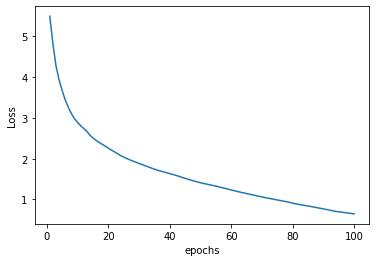

Test Accuracy
0.5082


In [22]:
#considering this subset of data as train data..
X_sample=X_train[:100]
Y_sample=Y_train_ohe[:100]

arch1=NN(input_shape=784,num_hlayers=1,neurons=[16],hiddenLayerActivation='Sigmoid',outputActivation='Softmax',optimizer='Adam',learningrate=1e-3,layerInitialization='Random',output_shape=10)


epochs=100
gd_v = GD_Versions(arch1,X_sample,Y_sample,epochs)
pred,loss_epoch=gd_v.SGD()
print("train accuracy")
print(np.sum(np.argmax(pred,axis=1)==np.argmax(Y_sample,axis=1))/len(Y_sample))

plt.plot(np.arange(1,epochs+1),loss_epoch)
plt.xlabel("epochs");plt.ylabel("Loss");plt.show()

print("Test Accuracy")
predtest=arch1.Final_Prediction(X_test)
print(np.sum(np.argmax(predtest,axis=1)==np.argmax(Y_test_ohe,axis=1))/len(Y_test))

train accuracy
0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


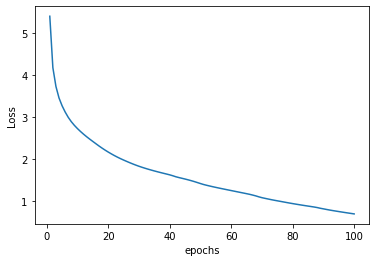

Test Accuracy
0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [57]:
#linear activation has y as scalar
X_sample=X_train[:100]
Y_s_reg=Y_train[:100]

arch1=NN(input_shape=784,num_hlayers=1,neurons=[16],hiddenLayerActivation='Sigmoid',outputActivation='Softmax',optimizer='Adam',learningrate=1e-3,layerInitialization='Random',output_shape=10)

epochs=100
gd_v = GD_Versions(arch1,X_sample,Y_sample,epochs)
pred,loss_epoch=gd_v.SGD()
print("train accuracy")
print(np.sum(pred == Y_s_reg)/len(Y_s_reg))

plt.plot(np.arange(1,epochs+1),loss_epoch)
plt.xlabel("epochs");plt.ylabel("Loss");plt.show()

print("Test Accuracy")
predtest=arch1.Final_Prediction(X_test)
print(np.sum(predtest==Y_s_reg)/len(Y_s_reg))

In [ ]:
cf=confusion_matrix(y_true=np.argmax(Y_test,axis=1),y_pred=np.argmax(predtest,axis=1))
plot_confusion_mtx(cf,10)

In [25]:
sweep_config = {
  "name": "My Sweep",
  "method": "bayes",
  "metric": {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
  "parameters": {
        "optimizer": {
            "values": ["Simple_GD","Adam","Nestrov","Nadam"]
        },
        "neurons":{
            "values":[32, 64, 128]
        },
        "num_hlayers":{
            "values":[1]
        },
        "hiddenLayerActivation":{
            "values":['Sigmoid','Relu','Tanh','Softmax','Linear']
        },
        "outputActivation":{
            "values":['Softmax','Linear']
        },
        "learningrate":{
            "values":[1e-3,1e-4]
        },
        "layerInitialization":{
            "values":['Random','Xavier']
        },
        "epochs":{
            "values":[100]
        }

    }
}

sweep_id = wandb.sweep(sweep_config, project='DeepLearning', entity='manideepladi')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: hnfquu91
Sweep URL: https://wandb.ai/manideepladi/DeepLearning/sweeps/hnfquu91


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: xnn7vxk8 with config:
wandb: 	epochs: 100
wandb: 	hiddenLayerActivation: Softmax
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.001
wandb: 	neurons: 64
wandb: 	num_hlayers: 1
wandb: 	optimizer: Adam
wandb: 	outputActivation: Softmax


train accuracy
0.93


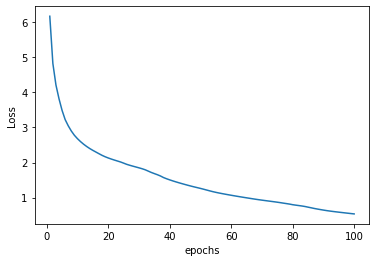

Test Accuracy
0.5363


Train accuracy,0.93
_runtime,7
_timestamp,1615459827
_step,1
Test accuracy,0.5363


Train accuracy,▁
_runtime,▁▁
_timestamp,▁▁
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: x2cc9sag with config:
wandb: 	epochs: 100
wandb: 	hiddenLayerActivation: Relu
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.0001
wandb: 	neurons: 64
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nadam
wandb: 	outputActivation: Linear


train accuracy
0.96


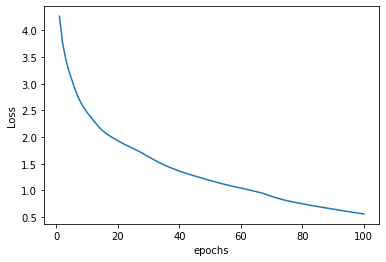

Test Accuracy
0.556


Train accuracy,0.96
_runtime,8
_timestamp,1615459841
_step,1
Test accuracy,0.556


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: gvbhhhn8 with config:
wandb: 	epochs: 100
wandb: 	hiddenLayerActivation: Sigmoid
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.001
wandb: 	neurons: 128
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nadam
wandb: 	outputActivation: Softmax


train accuracy
0.95


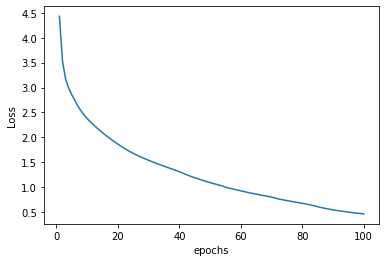

Test Accuracy
0.4955


Train accuracy,0.95
_runtime,8
_timestamp,1615459857
_step,1
Test accuracy,0.4955


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: ltppfnhu with config:
wandb: 	epochs: 100
wandb: 	hiddenLayerActivation: Tanh
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.001
wandb: 	neurons: 128
wandb: 	num_hlayers: 1
wandb: 	optimizer: Adam
wandb: 	outputActivation: Softmax


train accuracy
0.99


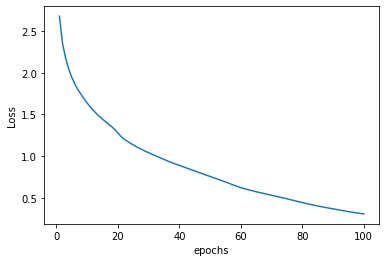

Test Accuracy
0.5501


Train accuracy,0.99
_runtime,8
_timestamp,1615459873
_step,1
Test accuracy,0.5501


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: 69s1msga with config:
wandb: 	epochs: 100
wandb: 	hiddenLayerActivation: Softmax
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.001
wandb: 	neurons: 32
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nestrov
wandb: 	outputActivation: Softmax


train accuracy
0.99


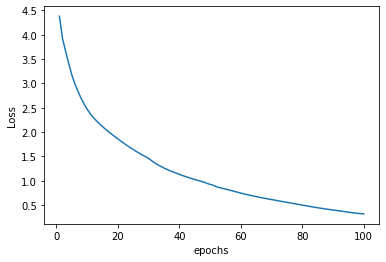

Test Accuracy
0.5545


Train accuracy,0.99
_runtime,9
_timestamp,1615459890
_step,1
Test accuracy,0.5545


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: krmbq9wr with config:
wandb: 	epochs: 100
wandb: 	hiddenLayerActivation: Relu
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.0001
wandb: 	neurons: 128
wandb: 	num_hlayers: 1
wandb: 	optimizer: Simple_GD
wandb: 	outputActivation: Softmax


train accuracy
0.96


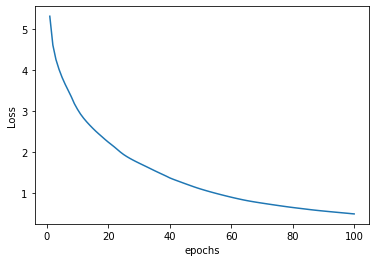

Test Accuracy
0.5503


Train accuracy,0.96
_runtime,9
_timestamp,1615459906
_step,1
Test accuracy,0.5503


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: 366knhcf with config:
wandb: 	epochs: 100
wandb: 	hiddenLayerActivation: Linear
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.001
wandb: 	neurons: 128
wandb: 	num_hlayers: 1
wandb: 	optimizer: Adam
wandb: 	outputActivation: Softmax


train accuracy
0.93


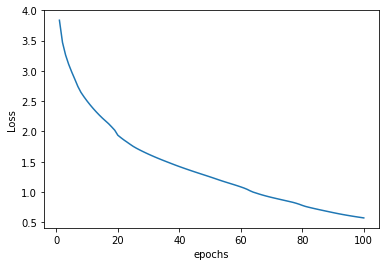

Test Accuracy
0.5852


Train accuracy,0.93
_runtime,8
_timestamp,1615459923
_step,1
Test accuracy,0.5852


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: 6jlcjsn8 with config:
wandb: 	epochs: 100
wandb: 	hiddenLayerActivation: Sigmoid
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.0001
wandb: 	neurons: 128
wandb: 	num_hlayers: 1
wandb: 	optimizer: Adam
wandb: 	outputActivation: Softmax


train accuracy
0.99


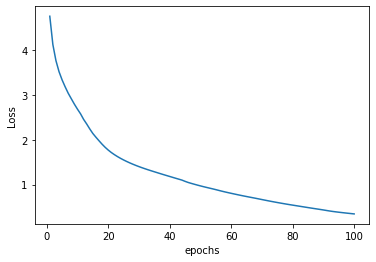

Test Accuracy
0.5339


Train accuracy,0.99
_runtime,8
_timestamp,1615459941
_step,1
Test accuracy,0.5339


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: mna2fgfy with config:
wandb: 	epochs: 100
wandb: 	hiddenLayerActivation: Linear
wandb: 	layerInitialization: Random
wandb: 	learningrate: 0.001
wandb: 	neurons: 32
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nadam
wandb: 	outputActivation: Softmax


train accuracy
0.96


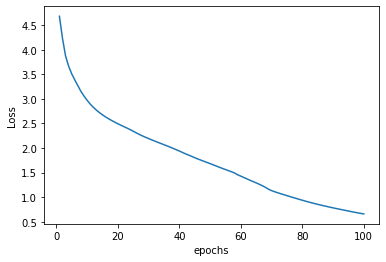

Test Accuracy
0.555


Train accuracy,0.96
_runtime,8
_timestamp,1615459958
_step,1
Test accuracy,0.555


Train accuracy,▁
_runtime,▁▁
_timestamp,▁▁
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: oipdtuqf with config:
wandb: 	epochs: 100
wandb: 	hiddenLayerActivation: Softmax
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.0001
wandb: 	neurons: 128
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nestrov
wandb: 	outputActivation: Linear


train accuracy
1.0


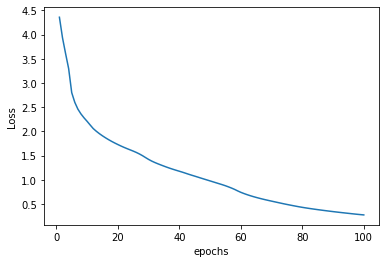

Test Accuracy
0.5679


Train accuracy,1.0
_runtime,8
_timestamp,1615459975
_step,1
Test accuracy,0.5679


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: fb6o3fsn with config:
wandb: 	epochs: 100
wandb: 	hiddenLayerActivation: Sigmoid
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.0001
wandb: 	neurons: 64
wandb: 	num_hlayers: 1
wandb: 	optimizer: Nadam
wandb: 	outputActivation: Linear


train accuracy
0.99


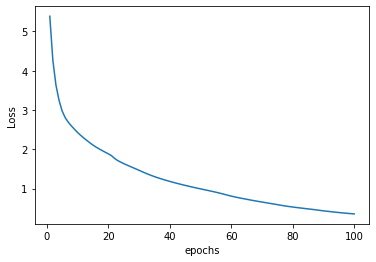

Test Accuracy
0.5962


Train accuracy,0.99
_runtime,9
_timestamp,1615459993
_step,1
Test accuracy,0.5962


Train accuracy,▁
_runtime,▁█
_timestamp,▁█
_step,▁█
Test accuracy,▁


wandb: Agent Starting Run: 8qerbzxk with config:
wandb: 	epochs: 100
wandb: 	hiddenLayerActivation: Relu
wandb: 	layerInitialization: Xavier
wandb: 	learningrate: 0.001
wandb: 	neurons: 128
wandb: 	num_hlayers: 1
wandb: 	optimizer: Simple_GD
wandb: 	outputActivation: Softmax


In [ ]:
def train():
  run = wandb.init()
  X_sample=X_train[:100]
  Y_sample=Y_train_ohe[:100]

  arch1=NN(input_shape=784,num_hlayers=1,neurons=[16],hiddenLayerActivation='Sigmoid',outputActivation='Softmax',optimizer='Adam',learningrate=1e-3,layerInitialization='Random',output_shape=10)
  epochs=100
  gd_v = GD_Versions(arch1,X_sample,Y_sample,epochs)
  pred,loss_epoch=gd_v.SGD()
  print("train accuracy")
  print(np.sum(np.argmax(pred,axis=1)==np.argmax(Y_sample,axis=1))/len(Y_sample))
  wandb.log({"Train accuracy": np.sum(np.argmax(pred,axis=1)==np.argmax(Y_sample,axis=1))/len(Y_sample)})

  plt.plot(np.arange(1,epochs+1),loss_epoch)
  plt.xlabel("epochs");plt.ylabel("Loss");plt.show()

  print("Test Accuracy")
  predtest=arch1.Final_Prediction(X_test)
  print(np.sum(np.argmax(predtest,axis=1)==np.argmax(Y_test_ohe,axis=1))/len(Y_test))   
  wandb.log({"Test accuracy": np.sum(np.argmax(predtest,axis=1)==np.argmax(Y_test_ohe,axis=1))/len(Y_test)})

wandb.agent(sweep_id, function=train)
#train()